# Deep Compression on LeNet

In this notebook, we study model compression techniques applied to LeNet, a convolutional neural network trained on the MNIST dataset.

LeNet is trained to classify handwritten digits (0–9) from 28×28 grayscale images.  
In our experiments, the baseline model is first trained for 50 epochs to reach a high classification accuracy.

The objective of this work is to apply the compression pipeline introduced in Song Han et al., _"Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization and Huffman Coding"_, in order to significantly reduce the model size while preserving its performance.

The deep compression method is composed of three main steps:
- **Pruning**: removing unimportant connections
- **Weight quantization**: reducing the precision of the remaining weights
- **Huffman coding**: applying entropy coding for further compression

We analyze the impact of each step on both model size and classification accuracy.

Finally, we compare the compressed model with a lightweight architecture that occupies a similar amount of storage.

<img src="../img/mnist.png">

In [1]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
from tqdm import tqdm


from src.models import LeNet, MiniLeNet
# import src.util

In [2]:
# Select Device
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

## MNIST dataset

Here is a brief overview of the MNIST dataset:
- Each 28×28 grayscale image represents a handwritten digit (from 0 to 9)
- Each image is associated with a label corresponding to the represented digit
- The dataset contains 60,000 training images and 10,000 test images

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 282kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.92MB/s]


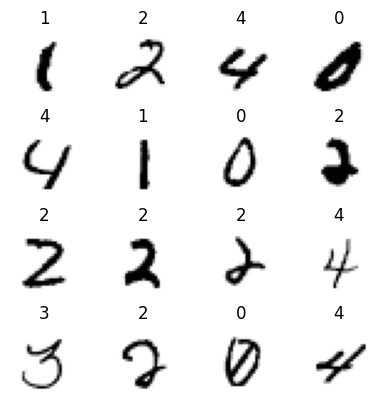

In [3]:
mean = {'LeNet' : (0.1307,)}
std  = {'LeNet' : (0.3081,)}

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean['LeNet'], std['LeNet'])
                    ])),
        batch_size=16, shuffle=True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(4,4))
for i in range(len(images)):
    l = labels[i].numpy()
    plt.subplot(4, 4, i+1)
    plt.title(f'{l}')
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')
plt.tight_layout(pad=0.5)
plt.show()

## LeNet Deep Compression

As introduced in Song Han et al., _"Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization and Huffman Coding"_, in order to significantly reduce the model size while preserving its performance.

To save time in this demo, the method has already been computed. Here are the saved models after the successive steps of pruning, weight quantization and huffman coding.


In [4]:
# Load models
model_init_path = '../saves/LeNet_initial_model.ptmodel'
model_init = torch.load(model_init_path, weights_only=False)
# model_pruned_retrained_path = '../saves/LeNet_model_after_retraining.ptmodel'
# model_pruned_retrained = torch.load(model_pruned_retrained_path, weights_only=False)
# model_weight_shared_path = '../saves/LeNet_model_after_weight_sharing.ptmodel'
# model_weight_shared = torch.load(model_weight_shared_path, weights_only=False)
model_decoded_path = '../saves/LeNet_model_after_decoding.ptmodel'
model_decoded = torch.load(model_decoded_path, weights_only=False)

# Display LeNet's architecture
print("LeNet's architecture :")
print(model_init)

LeNet's architecture :
LeNet(
  (fc1): MaskedLinear(in_features=784, out_features=300, bias=True)
  (fc2): MaskedLinear(in_features=300, out_features=100, bias=True)
  (fc3): MaskedLinear(in_features=100, out_features=10, bias=True)
)


In [5]:
def get_param_number(model):
    return sum(p.numel() for p in model.parameters())

def get_size_mb(model_path):
    return os.path.getsize(model_path) / 1024**2

In [6]:
print("Initial LeNet's parameter number :", get_param_number(model_init))
print(f"Storage space needed by initial LeNet : {get_size_mb(model_init_path):.2f} MB")

Initial LeNet's parameter number : 532810
Storage space needed by initial LeNet : 2.04 MB


In [7]:
print(f"{'Layer':30} {'Params':>12} {'Memory (MB)':>15}")
print("-" * 60)

total_mem = 0

for name, param in model_init.named_parameters():
    num_params = param.numel()
    mem_mb = num_params * param.element_size() / 1024**2
    total_mem += mem_mb
    print(f"{name:30} {num_params:12,d} {mem_mb:15.2f}")

print("-" * 60)
print(f"{'TOTAL':30} {'':12} {total_mem:15.2f} MB")

Layer                                Params     Memory (MB)
------------------------------------------------------------
fc1.weight                          235,200            0.90
fc1.mask                            235,200            0.90
fc1.bias                                300            0.00
fc2.weight                           30,000            0.11
fc2.mask                             30,000            0.11
fc2.bias                                100            0.00
fc3.weight                            1,000            0.00
fc3.mask                              1,000            0.00
fc3.bias                                 10            0.00
------------------------------------------------------------
TOTAL                                                  2.03 MB


### Pruning

First, a LeNet neural network has been trained for 50 epochs (sufficient for convergence). Then, we prune the weights by calculating a threshold to apply to all weight. The threshold is determined by multipling a quality factor ($s=0.25$) to the standard deviation of a layers' weigths. All weights whose absolute value is below the threshold are set to $0$. To finish the pruning step, we retrain the network while keeping the pruned weigths set to $0$.

In our example with LeNet, $95.53\% $ of the weights have been pruned

In [8]:
def display_loss_accuracy(training_data_path):
    training_data_mini = np.load(training_data_path)
    train_losses = training_data_mini['train_losses']
    test_losses = training_data_mini['test_losses']
    accs = training_data_mini['accs']

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(accs, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # plt.savefig('../img/training_curves.png', dpi=300)  # high quality
    plt.show()

In [20]:
# Comment.uncomment to see/hide details of the pruning step

with open('../saves/log_pruning.txt', 'r') as file:
    file_content = file.read()
    print(file_content)

--- Initial training ---
Test set: Average loss: 0.2246, Accuracy: 9413/10000 (94.13%)
--- Before pruning ---
fc1.weight           | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
fc1.bias             | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
fc2.weight           | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
fc2.bias             | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc3.weight           | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
fc3.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)
Pruning with threshold : 0.22580434381961823 for layer fc1
Pruning with threshold : 0.19193808734416962 for layer fc2
Pruning with threshold : 0.23468603193759918 fo

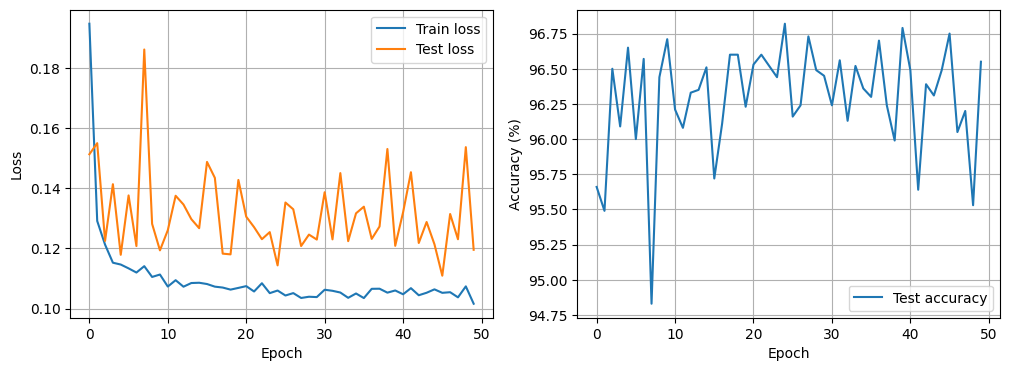

In [10]:
model_pruned_training_data_path = '../saves/training_data_lenet_pruned.npz'
display_loss_accuracy(model_pruned_training_data_path)

As you can see in the pruning steps details and the curves above, the accuracy of the model evolves as we prune it :
- Initial accuracy $94.13\%$
- Accuracy after pruning $57.31\%$
- Accuracy after retraining $96.55\%$

Before and after pruning, the accuracy remains stable.


### Weight quantization



In [11]:
with open('../saves/log_weight_sharing.txt', 'r') as file:
    file_content = file.read()
    print(file_content)

Before weight sharing
Test set: Average loss: 0.1196, Accuracy: 9655/10000 (96.55%)

After weight sharing
Test set: Average loss: 0.1209, Accuracy: 9648/10000 (96.48%)


### Huffman coding

We store the shared and pruned weigths in a way that saves even more space than to Huffman coding.

It is an encoding technique that uses a variable length code to represent a source symbol. The code is determined with an estimation of the apparenace probability of the source symbols. The shortest source symbols are associated with a short code.

In [12]:
with open('../saves/log_huffman_coding.txt', 'r') as file:
    file_content = file.read()
    print(file_content)

Layer           |   original compressed improvement percent
----------------------------------------------------------------------
fc1.weight      |      81244      18882       4.30x  23.24%
fc1.bias        |       1200       1200       1.00x 100.00%
fc2.weight      |      11860       3274       3.62x  27.61%
fc2.bias        |        400        400       1.00x 100.00%
fc3.weight      |        692        434       1.59x  62.72%
fc3.bias        |         40         40       1.00x 100.00%
----------------------------------------------------------------------
total           |      95436      24230       3.94x  25.39%


In [13]:
def get_folder_size_mb(folder_path):
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp):
                total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

model_encoded_path = os.path.expanduser('../encodings/')

size_mb = get_folder_size_mb(model_encoded_path)
size_kb = size_mb * 1024

print(f"Storage space needed by encoded LeNet : {size_kb:.2f} kB ({size_mb:.2f} MB)")


Storage space needed by encoded LeNet : 25.10 kB (0.02 MB)


### Compression rate after Deep Compression pipeline

In [14]:
print(f"LeNet compression rate with Pruning, Quantization and Huffman coding : {get_size_mb(model_init_path)/get_folder_size_mb(model_encoded_path):.1f}x")

LeNet compression rate with Pruning, Quantization and Huffman coding : 83.1x


## Experiment : Lightweight model design VS Deep Compression

The smallest version of our LeNet model takes less than 30kB to be stored.
Other papers mention lightweight model design as a way to save space.

We are going to create a mini version of LeNet that takes also less than 30kB to be stored, which has the same type of layers but with less parameters. This MiniLeNet model will be trained for 100 epochs, which is more than sufficient to reach convergence. Then, we will compare accuracies.

#### MiniLeNet

In [15]:
def train_test(model, epochs):
    kwargs = {'num_workers': 5, 'pin_memory': True} if use_cuda else {}
    device = torch.device("cuda" if use_cuda else 'cpu')

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean['LeNet'], std['LeNet'])
            ])),
        batch_size=100, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean['LeNet'], std['LeNet'])
            ])),
        batch_size=1000, shuffle=False, **kwargs)

    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        epoch_loss = 0

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (data, target) in pbar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # pruning-safe gradient masking
            for name, p in model.named_parameters():
                if 'mask' in name:
                    continue
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                p.grad.data = torch.from_numpy(
                    np.where(tensor == 0, 0, grad_tensor)
                ).to(device)

            optimizer.step()
            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                pbar.set_description(
                    f'Epoch {epoch} | Loss: {loss.item():.4f}'
                )

        train_losses.append(epoch_loss / len(train_loader))

        # ===== TEST =====
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(
                    output, target, reduction='sum'
                ).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        acc = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        accuracies.append(acc)

        print(
            f'Epoch {epoch:2d} | '
            f'Train loss: {train_losses[-1]:.4f} | '
            f'Test loss: {test_loss:.4f} | '
            f'Acc: {acc:.2f}%'
        )

    return train_losses, test_losses, accuracies

def test(model, use_cuda=True):
    kwargs = {'num_workers': 5, 'pin_memory': True} if use_cuda else {}
    device = torch.device("cuda" if use_cuda else 'cpu')


    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean['LeNet'], std['LeNet'])
                    ])),
        batch_size=1000, shuffle=False, **kwargs)
    
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        # print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss, accuracy


mini_model_path = '../saves/LeNet_mini.ptmodel'
mini_model_training_data_path = '../saves/training_data_minilenet.npz'

In [16]:
# # Create and train mini model
# mini_model = MiniLeNet(mask=False).to(device)
# train_losses, test_losses, accs = train_test(mini_model, epochs=100)
# torch.save(mini_model, mini_model_path)
# np.savez(mini_model_training_data_path, train_losses=train_losses, test_losses=test_losses, accs=accs)

In [17]:
# Load already trained mini model
mini_model_path = '../saves/LeNet_mini.ptmodel'
mini_model = torch.load(mini_model_path, weights_only=False)
print("MiniLeNet's parameter number :",sum(p.numel() for p in mini_model.parameters()))
size_kb_mini = os.path.getsize(mini_model_path) / 1024
print(f"Storage space needed by mini LeNet : {size_kb_mini:.2f} kB")
mini_model

MiniLeNet's parameter number : 6442
Storage space needed by mini LeNet : 29.06 kB


MiniLeNet(
  (fc1): Linear(in_features=784, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
)

Display loss and accuracy for MiniLeNet

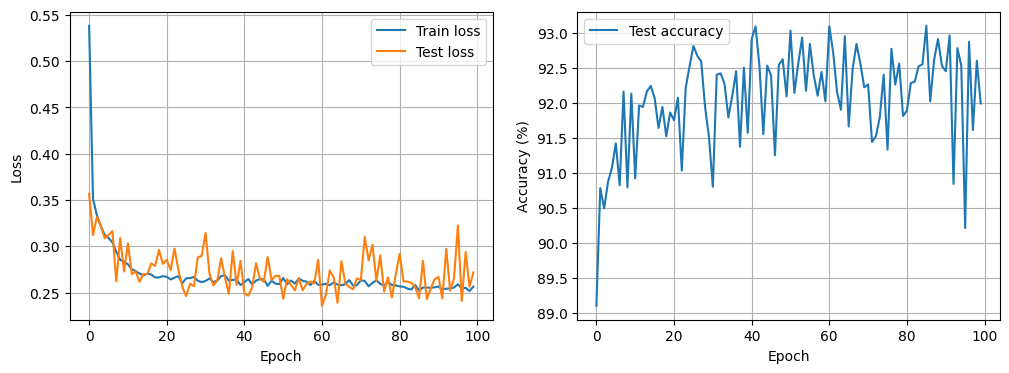

In [18]:
display_loss_accuracy(mini_model_training_data_path)

#### Comparison : MiniLeNet VS Deep Compressed LeNet

In [19]:
print(f"{'Model':20} {'Memory (kB)':>15} {'Average loss':>15} {'Accuracy':>15}")
print("-" * 80)

# mem_space_mb = [get_size_mb(model_init_path), get_folder_size_mb(model_encoded_path), get_size_mb(mini_model_path)] * 1024

for i, path in enumerate([model_init_path, model_encoded_path, mini_model_path]):
    model = torch.load(path, weights_only=False) if os.path.isfile(path) else torch.load(model_decoded_path, weights_only=False)
    num_params = sum(p.numel() for p in model.parameters())
    avg_loss, accuracy = test(model, use_cuda=use_cuda)
    mem_space_mb = get_size_mb(path) if os.path.isfile(path) else get_folder_size_mb(path)
    print(f"{type(model).__name__:20} {mem_space_mb*1024:15.2f} {avg_loss:15.4f} {accuracy:15.2f}")

# print("-" * 80)
# print(f"{'TOTAL':30} {'':12} {:15.2f} MB")

Model                    Memory (kB)    Average loss        Accuracy
--------------------------------------------------------------------------------
LeNet                        2085.97          0.2246           94.13
LeNet                          25.10          0.1209           96.48
MiniLeNet                      29.06          0.2718           91.99


We observe that the accuracy of MiniLeNet remains reasonably close to that of the original LeNet model. This highlights the trade-off between model size and performance, demonstrating that significant compression can be achieved with only a modest impact on accuracy.